### 0.0 Setup

In [1]:
# Package for converting molecular data from SMILE to graph format
pip -q install rdkit-pypi

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip -q install pandas
!pip -q install Pillow
!pip -q install matplotlib
!pip -q install pydot
#sudo apt-get -qq install graphviz

In [1]:
import os

# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

# Temporary suppress warnings and RDKit logs
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(42)
tf.random.set_seed(42)

### 0.1 Dataset

In [2]:
csv_path = keras.utils.get_file(
    "BBBP.cvs", "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv"
)

df = pd.read_csv(csv_path, usecols = [1, 2, 3])
df.iloc[96:104]

,name,p_np,smiles
96,cefoxitin,1,CO[C@]1(NC(=O)Cc2sccc2)[C@H]3SCC(=C(N3C1=O)C(O...
97,Org34167,1,NC(CC=C)c1ccccc1c2noc3c2cccc3
98,9-OH Risperidone,1,OC1C(N2CCC1)=NC(C)=C(CCN3CCC(CC3)c4c5ccc(F)cc5...
99,acetaminophen,1,CC(=O)Nc1ccc(O)cc1
100,acetylsalicylate,0,CC(=O)Oc1ccccc1C(O)=O
101,allopurinol,0,O=C1N=CN=C2NNC=C12
102,Alprostadil,0,CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)CC(=O)[C@@H]1C...
103,aminophylline,0,CN1C(=O)N(C)c2nc[nH]c2C1=O.CN3C(=O)N(C)c4nc[nH...


### 1.0 Extructing features

In [3]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)
            
    def encode(self, inputs):
        output = np.zeros((self.dim, ))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output
    
    
class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        
    def symbol(self, atom):
        return atom.GetSymbol()
    
    def n_valence(self, atom):
        return atom.GetTotalValence()
    
    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()
    
    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()
    
class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1
        
    def encode(self, bond):
        output = np.zeros((self.dim, ))
        if bond is None:
            output[-1] = 1.
            return output
        
        output = super().encode(bond)
        return output
    
    def bond_type(self, bond):
        return bond.GetBondType().name.lower()
    
    def conjugated(self, bond):
        return bond.GetIsConjugated()
    
atom_featurizer = AtomFeaturizer(
        allowable_sets = {
            "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
            "n_valence": {0, 1, 2, 3, 4, 5, 6},
            "n_hydrogens": {0, 1, 2, 3, 4},
            "hybridization": {"s", "sp", "sp2", "sp3"}
        }
)

bond_featurizer = BondFeaturizer(
    allowable_sets = {
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)

In [4]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize = True) should be equivalent to
    # MolFromSmiles(m, sanitize = False) -> Sanitize(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize = False)
    
    # If the sanitization is unsuccessfull, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors = True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps = Chem.SanitizeFlags.SANITIZE_ALL ^ flag)
        
    Chem.AssignStereochemistry(molecule, cleanIt = True, force = True)
    
    return molecule

def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []
    
    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))
        
        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))
        
        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))
            
    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)
    

def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []
    
    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)
        
        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)
        
    # Convert lists to ragged tensors (list analog in TF) for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype = tf.float32),
        tf.ragged.constant(bond_features_list, dtype = tf.float32),
        tf.ragged.constant(pair_indices_list, dtype = tf.int64)

    )

In [5]:
# Shuffle array if indices ranging from 0 to 2049
permutted_indices = np.random.permutation(np.arange(df.shape[0]))

# Train set: 80% of data
train_index = permutted_indices[:int(df.shape[0] * 0.8)]
x_train = graphs_from_smiles(df.iloc[train_index].smiles)
y_train = df.iloc[train_index].p_np

# Valid set: 19% of data
valid_index = permutted_indices[int(df.shape[0] * 0.8):int(df.shape[0] * 0.99)]
x_valid = graphs_from_smiles(df.iloc[valid_index].smiles)
y_valid = df.iloc[valid_index].p_np

# Test set: 1% of data
test_index = permutted_indices[int(df.shape[0] * 0.99):]
x_test = graphs_from_smiles(df.iloc[test_index].smiles)
y_test = df.iloc[test_index].p_np

Name:	acetylsalicylate
SMILES:	CC(=O)Oc1ccccc1C(O)=O
BBB:	0
Molecule:


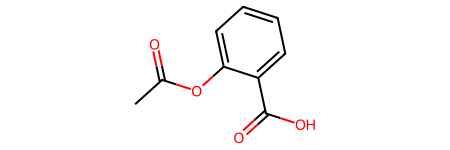

In [6]:
# Test the functions

print(f"Name:\t{df.name[100]}\nSMILES:\t{df.smiles[100]}\nBBB:\t{df.p_np[100]}")
molecule = molecule_from_smiles(df.iloc[100].smiles)
print("Molecule:")
molecule

In [7]:
graph = graph_from_molecule(molecule)
print("Graph including self-loops:")
print("\tatom features", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices", graph[2].shape)

Graph including self-loops:
	atom features (13, 29)
	bond features	 (39, 7)
	pair indices (39, 2)


### 1.1 Creating a merged graph from a collection of graphs

In [8]:
def prepare_batch(x_batch, y_batch):
    """Merges (sub) graphs of batch into a single global (disconnected) graph
    """
    
    atom_features, bond_features, pair_indices = x_batch
    
    # Obtain number of atoms and bonds of each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()
    
    # Obtain partition indices (molecule_indicator) which will be used to
    # grather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)
    
    # Merge (sub)graphs into a global (disconnected) graph. Adding "increment" to
    # "pair_indices" (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis = 0, inner_axis = 1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis = 0, inner_axis = 1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis = 0, inner_axis = 1).to_tensor()
    
    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch

def MPNNDataset(X, y, batch_size = 32, shuffle = False):
    dataset = tf.data.Dataset.from_tensor_slices((X, [y]))
    
    if shuffle:
        dataset = dataset.shuffle(1024)
        
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)

def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)

### 2.0 Model. Message Passing

In [9]:
class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape = (self.bond_dim, self.atom_dim * self.atom_dim),
            initializer = 'glorot_uniform',
            name = 'kernel',
        )
        self.bias = self.add_weight(
            shape = (self.atom_dim * self.atom_dim), initializer = 'zeros', name = 'bias',
        )
        
        self.built = True
        
    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs
        
        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias
        
        # Reshape for neighbour aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))
        
        # Obtain atom features of neighbours
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis = -1)
        
        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis = -1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        
        return aggregated_features
    
class MessagePassing(layers.Layer):
    def __init__(self, units, steps = 4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps
        
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        
        # layers.GRUCell saves the current state of the node
        # and uses it to update the next state
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True
        
    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs
        
        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dence layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])
        
        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )
            
            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                   atom_features_aggregated, atom_features_updated
            )
            
        return atom_features_updated


### 2.1 Model. Readout

In [10]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        
    def call(self, inputs):
        
        atom_features, molecule_indicator = inputs
        
        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )
        
        
        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis = 0,
        )
        
        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis = -1)
        return tf.gather(atom_features_stacked, gather_indices, axis = 0)
    
class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads = 8, embed_dim = 64, dense_dim = 512, batch_size = 32, **kwargs
    ):
        super().__init__(**kwargs)
        
        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation='relu'), layers.Dense(embed_dim)]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()
        
    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis = -1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask = padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)

### 2.2 Model. MPNN

In [11]:
def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size = 32,
    message_units = 64,
    message_steps = 4,
    num_attention_heads = 8,
    dense_units = 612,
):
    
    atom_features = layers.Input((atom_dim), dtype = "float32", name = 'atom_features')
    bond_features = layers.Input((bond_dim), dtype = "float32", name = 'bond_features')
    pair_indices = layers.Input((2), dtype = "int32", name = 'pair_indices')
    molecule_indicator = layers.Input((), dtype = "int32", name = 'molecule_indicator')
    
    x = MessagePassing(message_units, message_steps)(
           [atom_features, bond_features, pair_indices]
    )
    
    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])
    
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dense(1, activation = 'sigmoid')(x)
    
    model = keras.Model(
        inputs = [atom_features, bond_features, pair_indices, molecule_indicator],
        outputs = [x],
    )
    
    return model


In [12]:
mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim = x_train[1][0][0].shape[0]
)

mpnn.compile(
    loss = keras.losses.BinaryFocalCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=5e-4),
    metrics = [keras.metrics.AUC(name = 'AUC')]
)

#keras.utils.plot_model(mpnn, show_dtype = True, show_shapes = True)

### 3.0 Training

In [13]:
len(x_train)

3

In [17]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

history = mpnn.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = 40,
    verbose = 2,
    class_weight = {0:2.0, 1:0.5}
)

Epoch 1/40
52/52 - 1s - loss: 0.0575 - AUC: 0.9607 - val_loss: 0.1037 - val_AUC: 0.9034 - 563ms/epoch - 11ms/step
Epoch 2/40
52/52 - 1s - loss: 0.0601 - AUC: 0.9563 - val_loss: 0.1087 - val_AUC: 0.8987 - 528ms/epoch - 10ms/step
Epoch 3/40
52/52 - 1s - loss: 0.0616 - AUC: 0.9541 - val_loss: 0.1073 - val_AUC: 0.9114 - 530ms/epoch - 10ms/step
Epoch 4/40
52/52 - 1s - loss: 0.0584 - AUC: 0.9591 - val_loss: 0.1129 - val_AUC: 0.9000 - 530ms/epoch - 10ms/step
Epoch 5/40
52/52 - 1s - loss: 0.0542 - AUC: 0.9640 - val_loss: 0.1084 - val_AUC: 0.9090 - 527ms/epoch - 10ms/step
Epoch 6/40
52/52 - 1s - loss: 0.0517 - AUC: 0.9673 - val_loss: 0.1109 - val_AUC: 0.9039 - 530ms/epoch - 10ms/step
Epoch 7/40
52/52 - 1s - loss: 0.0546 - AUC: 0.9643 - val_loss: 0.0915 - val_AUC: 0.9210 - 532ms/epoch - 10ms/step
Epoch 8/40
52/52 - 1s - loss: 0.0529 - AUC: 0.9657 - val_loss: 0.1145 - val_AUC: 0.9020 - 529ms/epoch - 10ms/step
Epoch 9/40
52/52 - 1s - loss: 0.0516 - AUC: 0.9659 - val_loss: 0.1244 - val_AUC: 0.8957 

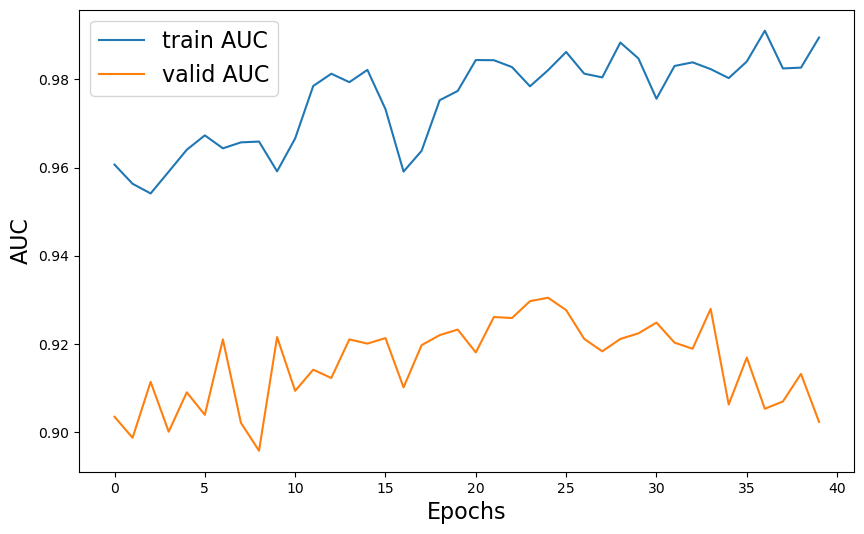

In [18]:
plt.figure(figsize = (10, 6))
plt.plot(history.history["AUC"], label = 'train AUC')
plt.plot(history.history["val_AUC"], label = 'valid AUC')
plt.xlabel("Epochs", fontsize = 16)
plt.ylabel("AUC", fontsize = 16)
plt.legend(fontsize = 16)

1/1 [==============================] - 0s 86ms/step


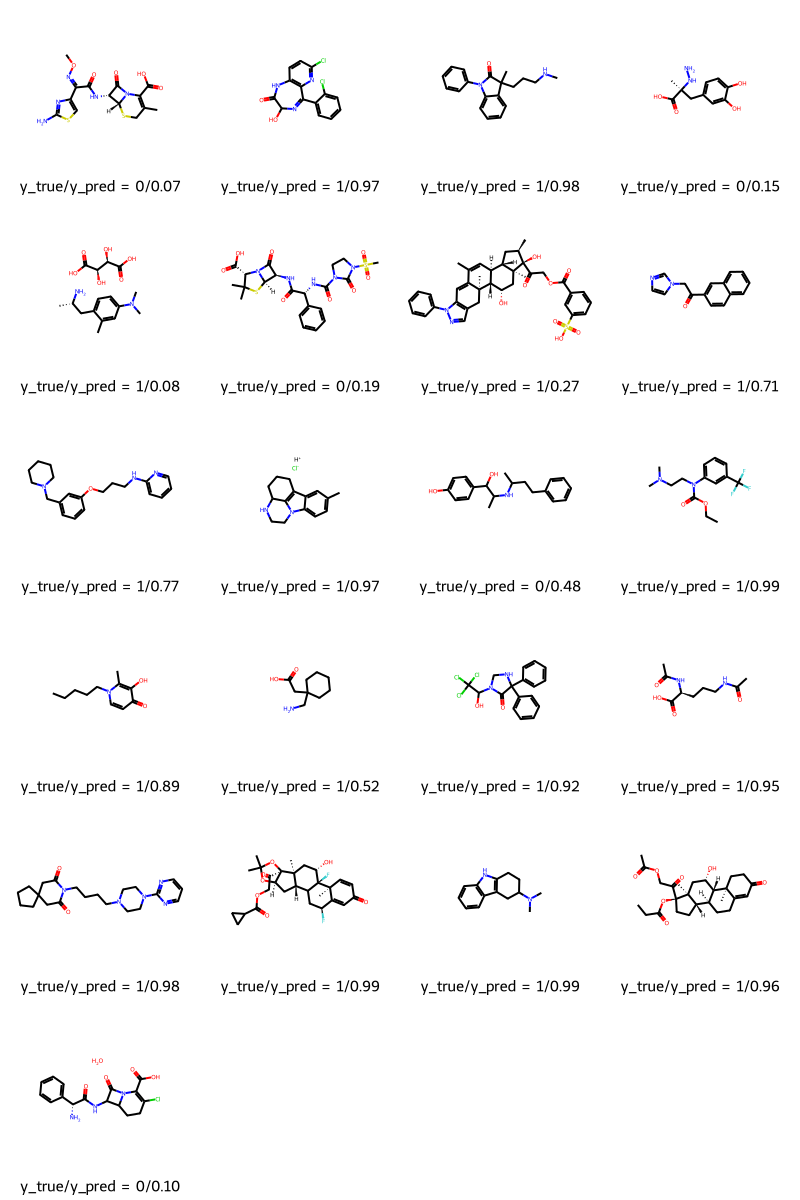

In [20]:
molecules = [molecule_from_smiles(df.smiles.values[index]) for index in test_index]

y_true = [df.p_np.values[index] for index in test_index]
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis = 1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow = 4, legends = legends)